In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import random
import seaborn as sns

import scipy.spatial

import networkx as nx
import itertools


np.random.seed(0)
random.seed(0)

In [2]:
import sys
sys.path.append("../../..")
from decipher.load_data import palette_original
palette_original["normal"] = palette_original["Healthy"]
palette_original["perturbed"] = palette_original["AML1"]


In [3]:
sc.settings.set_figure_params(dpi_save=1200, vector_friendly=True, fontsize=18)
plt.rcParams['axes.grid'] = False

In [4]:
def load_data(path):
    adata = sc.read_h5ad(path)
    adata.obs["origin"].replace(
        {
            "p89": "perturbed",
            "tet2_p1": "perturbed",
            "tet2_p3": "perturbed",
            "AML1": "perturbed",
            "AML2": "perturbed",
            "AML3": "perturbed",
            "healthy": "normal",
            "Healthy": "normal",
        },
        inplace=True,
    )
    return adata


In [5]:
def gene_marker(adata, gene, threshold=0.9):
    return (
        adata[:, gene].X.toarray()[:, 0]
        > np.quantile(adata[:, gene].X.toarray()[:, 0], threshold)
    ).astype(float)


def compute_location_score(
    adata, obsm_key, mode=0, get_distances=False, scale=5, power=1, agg="mean"
):
    # form 3 stages for normal data
    # - Stage 1: cd34+
    # - Stage 3: mpo+
    # - Stage 2: the in-between cells

    normal = adata[adata.obs["origin"] == "normal"]
    normal_immature = normal[normal.obs["cell_type_merged"] == "immature"]
    normal_immature.obs["CD34+"] = gene_marker(normal_immature, "CD34", 0.9)
    normal_immature.obs["MPO+"] = gene_marker(normal_immature, "MPO", 0.7)
    normal_stage1 = normal_immature[normal_immature.obs["CD34+"] > 0]
    normal_stage2 = normal_immature[
        (normal_immature.obs["CD34+"] < 1) & (normal_immature.obs["MPO+"] < 1)
    ]
    normal_stage3 = normal_immature[normal_immature.obs["MPO+"] > 0]

    perturbed = adata[adata.obs["origin"] == "perturbed"]
    perturbed_immature = perturbed[perturbed.obs["cell_type_merged"] == "immature"]
    perturbed_blast0 = perturbed[perturbed.obs["cell_type_merged"] == "blast0"]
    perturbed_blast1 = perturbed[perturbed.obs["cell_type_merged"] == "blast1"]
    perturbed_blast2 = perturbed[perturbed.obs["cell_type_merged"] == "blast2"]
    perturbed_blast3 = perturbed[perturbed.obs["cell_type_merged"] == "blast3"]

    # save benchmark group
    key = "benchmark_group"
    adata.obs[key] = None
    adata.obs.loc[perturbed_immature.obs.index, key] = "perturbed_immature"
    adata.obs.loc[perturbed_blast0.obs.index, key] = "perturbed_blast0"
    adata.obs.loc[perturbed_blast1.obs.index, key] = "perturbed_blast1"
    adata.obs.loc[perturbed_blast2.obs.index, key] = "perturbed_blast2"
    adata.obs.loc[perturbed_blast3.obs.index, key] = "perturbed_blast3"
    adata.obs.loc[normal_stage1.obs.index, key] = "normal_stage1"
    adata.obs.loc[normal_stage2.obs.index, key] = "normal_stage2"
    adata.obs.loc[normal_stage3.obs.index, key] = "normal_stage3"

    groups = {
        "normal_stage1": normal_stage1,
        "normal_stage2": normal_stage2,
        "normal_stage3": normal_stage3,
        "perturbed_immature": perturbed_immature,
        "perturbed_blast0": perturbed_blast0,
        "perturbed_blast1": perturbed_blast1,
        "perturbed_blast2": perturbed_blast2,
        "perturbed_blast3": perturbed_blast3,
    }
    neighbor_groups = [
        ("normal_stage1", "normal_stage2"),
        ("normal_stage2", "normal_stage3"),
        ("normal_stage1", "perturbed_immature"),
        ("perturbed_immature", "perturbed_blast0"),
        ("perturbed_blast0", "perturbed_blast1"),
        ("perturbed_blast1", "perturbed_blast2"),
        ("perturbed_blast2", "perturbed_blast3"),
    ]
    neighbor_groups = set(map(tuple, map(sorted, neighbor_groups)))
    score = 0

    sampled_distances = scipy.spatial.distance.cdist(
        sc.pp.subsample(adata, n_obs=2000, copy=True).obsm[obsm_key],
        sc.pp.subsample(adata, n_obs=2000, copy=True).obsm[obsm_key],
    )
    intrinsic_distance = sampled_distances.mean()

    distances = []

    for n1, n2 in itertools.combinations(groups.keys(), 2):
        if not len(groups[n1].obsm[obsm_key]) or not len(groups[n2].obsm[obsm_key]):
            continue
        distance = np.mean(
            (
                scipy.spatial.distance.cdist(
                    groups[n1].obsm[obsm_key],
                    groups[n2].obsm[obsm_key],
                )
            ).flatten()
        )
        distances.append(
            [n1, n2, tuple(sorted([n1, n2])) not in neighbor_groups, distance]
        )

    distances = pd.DataFrame(
        distances,
        columns=["n1", "n2", "d>1", "distance"],
    )
    distances["distance"] /= intrinsic_distance

    distances["origin1"] = distances["n1"].str.split("_").str[0]
    distances["origin2"] = distances["n2"].str.split("_").str[0]

    df = distances

    df["score_ordering"] = (df["distance"] ** power) * (df["origin1"] == df["origin2"])
    df_ordering = df.groupby(["d>1"]).mean()
    score_ordering = (
        df_ordering.loc[True, "score_ordering"]
        / df_ordering.loc[False, "score_ordering"]
    )

    df["score_divergence"] = (df["distance"] ** power) * (
        df["origin1"] != df["origin2"]
    )
    df["score_divergence"].replace(0, np.nan, inplace=True)
    df_divergence = df.groupby(["d>1"]).mean()
    score_divergence = (
        df_divergence.loc[True, "score_divergence"]
        - 2 * df_divergence.loc[False, "score_divergence"]
    )
    return score_ordering, score_divergence

/opt/miniconda3/envs/latent-manifold-scvi/lib/python3.7/site-packages/ipykernel_launcher.py:18: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/opt/miniconda3/envs/latent-manifold-scvi/lib/python3.7/site-packages/ipykernel_launcher.py:18: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/opt/miniconda3/envs/latent-manifold-scvi/lib/python3.7/contextlib.py:119: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)
/opt/miniconda3/envs/latent-manifold-scvi/lib/python3.7/site-packages/ipykernel_launcher.py:18: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/opt/miniconda3/envs/latent-manifold-scvi/lib/python3.7/contextlib.p

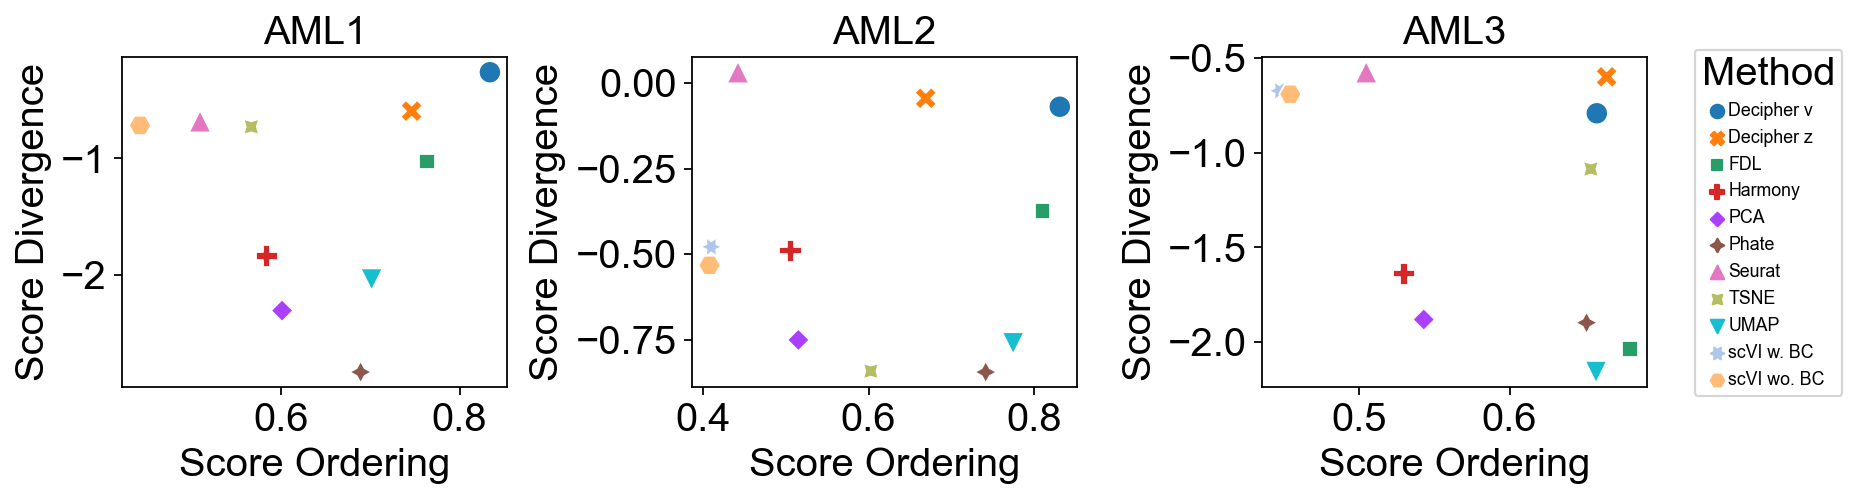

In [6]:
fig, axs = plt.subplots(1, 3, figsize=[12, 3.5])
for i in range(3):
    scores = []
    for path, name, attr in [
        (f"outputs/aml{i+1}/decipher.h5ad", "Decipher v", "decipher_v"),
        (f"outputs/aml{i+1}/decipher.h5ad", "Decipher z", "decipher_z"),
        (f"outputs/aml{i+1}/force_atlas2.h5ad", "FDL", "X_draw_graph_fa"),
        (f"outputs/aml{i+1}/harmony.h5ad", "Harmony", "X_pca_harmony"),
        (f"outputs/aml{i+1}/pca-umap-tsne.h5ad", "PCA", "X_pca"),
        (f"outputs/aml{i+1}/phate.h5ad", "Phate", "phate"),
        (f"outputs/aml{i+1}/seurat.h5ad", "Seurat", "X_pca"),
        (f"outputs/aml{i+1}/pca-umap-tsne.h5ad", "TSNE", "X_tsne"),
        (f"outputs/aml{i+1}/pca-umap-tsne.h5ad", "UMAP", "X_umap"),
        (f"outputs/aml{i+1}/scvi.h5ad", "scVI w. BC", "X_scVI"),
        (f"outputs/aml{i+1}/scvi_no_effects.h5ad", "scVI wo. BC", "X_scVI_noeffects"),
    ]:
        adata = load_data(path)
        score = compute_location_score(adata, attr)
        scores.append([name, *score])
    tmp = pd.DataFrame(scores, columns=["method", "score_ordering", "score_divergence"])
    sns.scatterplot(
        data=tmp,
        x="score_ordering",
        y="score_divergence",
        hue="method",
        style="method",
        s=100,
        ax=axs[i],
    )
    if i < 2:
        axs[i].get_legend().set_visible(False)
    else:
        axs[i].legend(bbox_to_anchor=(1.1, 1.05), title="Method", fontsize=8)

    axs[i].set_title(f"AML{i+1}")
    axs[i].set_xlabel(f"Score Ordering")
    axs[i].set_ylabel(f"Score Divergence")
fig.tight_layout()